# EMBC16.ipynb

## EMBC 2016—Scoring Sequences of Hippocampal Activity using Hidden Markov Models

Jupyter notebook showing how to generate all the figures and results presented in our EMBC '16 paper.

### Import packages and initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from IPython.display import display, clear_output

sys.path.insert(0, 'helpers')

from efunctions import * # load my helper function(s) to save pdf figures, etc.
from hc3 import load_data, get_sessions
from hmmlearn import hmm # see https://github.com/ckemere/hmmlearn
import klabtools as klab
import seqtools as sq

import importlib

importlib.reload(sq) # reload module here only while prototyping...
importlib.reload(klab) # reload module here only while prototyping...

%matplotlib inline

sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 1.5})
sns.set_style("white")

function saveFigure(filename) loaded

Tip: to save a figure, call saveFigure("path/figure.pdf")


### Define helper function(s)

In [2]:
from mymap import Map

def extract_subsequences_from_binned_spikes(binned_spikes, bins):
    data = spikes.data.copy()
    boundaries = klab.get_continuous_segments(bins)
    
    binned = Map()
    binned['bin_width'] = binned_spikes.bin_width
    binned['data'] = binned_spikes.data[bins,:]
    binned['boundaries'] = boundaries
    binned['boundaries_fs'] = 1/binned_spikes.bin_width   
    binned['sequence_lengths'] = (boundaries[:,1] - boundaries[:,0] + 1).flatten()
    
    return binned

### Load data

Here we consider lin2 data for gor01 on the first recording day (6-7-2006), since this session had the most units (91) of all the gor01 sessions, and lin2 has position data, whereas lin1 only has partial position data.

In [3]:
datadirs = ['/home/etienne/Dropbox/neoReader/Data',
            'C:/etienne/Dropbox/neoReader/Data',
            '/Users/etienne/Dropbox/neoReader/Data']

fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)

animal = 'gor01'; month,day = (6,7); session = '16-40-19' # 91 units

spikes = load_data(fileroot=fileroot, datatype='spikes',animal=animal, session=session, month=month, day=day, fs=32552, verbose=False)
eeg = load_data(fileroot=fileroot, datatype='eeg', animal=animal, session=session, month=month, day=day,channels=[0,1,2], fs=1252, starttime=0, verbose=False)
posdf = load_data(fileroot=fileroot, datatype='pos',animal=animal, session=session, month=month, day=day, verbose=False)
speed = klab.get_smooth_speed(posdf,fs=60,th=8,cutoff=0.5,showfig=False,verbose=False)

reading position data from '/home/etienne/Dropbox/neoReader/Data/gor01-6-7/2006-6-7_16-40-19/2006-6-7_16-40-19.whl'


### Model selection

Here we split our data into train, test, and validation sets. We perform model selection by training on our train set, and evaluating the model on data from our validation set (the test set is never touched by the model!). We then look at the log likelihood (normalized for sequence length) for a range of number of model states, and we choose the smallest number of model states after which the log likelihood does not seem to improve on the validation set. This is akin to cross validation.

We also plot the log likelihood of the test data, where it is important to note that these results did not influence the training or decision for the number of states in any way, but we choose to show it merely to demonstrate that the test and validation sets have similar _shapes_, as expected.

In [4]:
## bin ALL spikes
ds = 0.125 # bin spikes into 125 ms bins (theta-cycle inspired)
binned_spikes_all = klab.bin_spikes(spikes.data, ds=ds, fs=spikes.samprate, verbose=True)

## identify boundaries for running (active) epochs and then bin those observations into separate sequences:
runbdries = klab.get_boundaries_from_bins(eeg.samprate,bins=speed.active_bins,bins_fs=60)
binned_spikes_bvr = klab.bin_spikes(spikes.data, fs=spikes.samprate, boundaries=runbdries, boundaries_fs=eeg.samprate, ds=ds)

binning data into 20703 x 125.0 ms temporal bins...


In [5]:
## stack data for hmmlearn:
seq_stk_bvr = sq.data_stack(binned_spikes_bvr, verbose=True)
seq_stk_all = sq.data_stack(binned_spikes_all, verbose=True)

## split data into train, test, and validation sets:
tr_b,vl_b,ts_b = sq.data_split(seq_stk_bvr, tr=60, vl=20, ts=20, randomseed = 0, verbose=False)

90 sequences being stacked...
Total sequence length: 1938 bins, each of width 0.125 seconds
Successfully stacked 90 sequences for a total of 242.25 seconds of data.
Only one sequence in data; so data is already in stacked format...


In [6]:
Smax = 40
S = np.arange(start=5,step=1,stop=Smax+1)

tr_ll = []
vl_ll = []
ts_ll = []

for num_states in S:
    clear_output(wait=True)
    print('Training and evaluating {}-state hmm'.format(num_states))
    sys.stdout.flush()
    myhmm = sq.hmm_train(tr_b, num_states=num_states, n_iter=30, verbose=False)
    tr_ll.append( (np.array(list(sq.hmm_eval(myhmm, tr_b)))/tr_b.sequence_lengths ).mean())
    vl_ll.append( (np.array(list(sq.hmm_eval(myhmm, vl_b)))/vl_b.sequence_lengths ).mean())
    ts_ll.append( (np.array(list(sq.hmm_eval(myhmm, ts_b)))/ts_b.sequence_lengths ).mean())

clear_output(wait=True)
print('Done!')
sys.stdout.flush()

Done!


(5, 40)

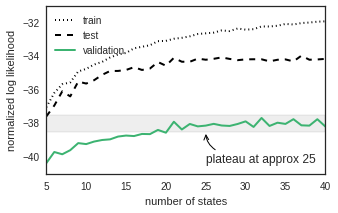

In [7]:
num_states = 25

fig = plt.figure(1, figsize=(5, 3))
ax = fig.add_subplot(111)
    
ax.annotate('plateau at approx ' + str(num_states), xy=(num_states, -38.5), xycoords='data',
                xytext=(0, -30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle3,angleA=0,angleB=-90", lw=1)
                )

ax.plot(S, tr_ll, lw=2, linestyle='dotted', label='train', color='k')
ax.plot(S, ts_ll, lw=2, linestyle='dashed', label='test', color='k')
ax.plot(S, vl_ll, lw=2, linestyle='solid', label='validation', color='mediumseagreen')
ax.legend(loc=2)
ax.set_xlabel('number of states')
ax.set_ylabel('normalized log likelihood')

ax.axhspan(-38.5, -37.5, facecolor='0.75', alpha=0.25)
ax.set_xlim([5, S[-1]])

#saveFigure('figures/modelselection.pdf')

### Model validation

Here we take a look at the states that were learned by the model, and we show that even though both place cells and interneurons (which do not have place-selective firing fields) have been used to train the model, the model effectively learned only place-specific and relevant states, which we can think of as virtual place cells.

In [8]:
## bin ALL spikes
ds = 0.125 # bin spikes into 125 ms bins (theta-cycle inspired)
binned_spikes = klab.bin_spikes(spikes.data, ds=ds, fs=spikes.samprate, verbose=True)

centerx = (np.array(posdf['x1']) + np.array(posdf['x2']))/2
centery = (np.array(posdf['y1']) + np.array(posdf['y2']))/2

tend = len(speed.data)/speed.samprate # end in seconds
time_axis = np.arange(0,len(speed.data))/speed.samprate
speed_125, tvel_125 = klab.resample_velocity(velocity=speed.data,t_bin=ds,tvel=time_axis,t0=0,tend=tend)
truepos_125 = np.interp(np.arange(0,len(binned_spikes.data))*ds,time_axis,centerx)

# get bins where rat was running faster than thresh units per second
runidx_125 = np.where(speed_125>8)[0]
seq_stk_run_125 = extract_subsequences_from_binned_spikes(binned_spikes,runidx_125)

## split data into train, test, and validation sets:
tr_b2,vl_b2,ts_b2 = sq.data_split(seq_stk_run_125, tr=60, vl=10, ts=30, randomseed = 0, verbose=True)

## train HMM on active behavioral data; training set (with a fixed, arbitrary number of states for now):
num_states = 25
myhmm2 = sq.hmm_train(tr_b2, num_states=num_states, n_iter=50, verbose=False)

binning data into 20703 x 125.0 ms temporal bins...
Splitting 90 sequences into train, validation, and test sets...
54 sequences being stacked...
Total sequence length: 1135 bins, each of width 0.125 seconds
Successfully stacked 54 sequences for a total of 141.88 seconds of data.
9 sequences being stacked...
Total sequence length: 170 bins, each of width 0.125 seconds
Successfully stacked 9 sequences for a total of 21.25 seconds of data.
27 sequences being stacked...
Total sequence length: 591 bins, each of width 0.125 seconds
Successfully stacked 27 sequences for a total of 73.88 seconds of data.
Stacked data split into train (60.0 %), validation (10.0 %) and test (30.0 %) sequences.


In [9]:
###########################################################3
stacked_data = seq_stk_run_125
###########################################################3

x0=0; xl=100; num_pos_bins=50
xx_left = np.linspace(x0,xl,num_pos_bins+1)
num_sequences = len(stacked_data.sequence_lengths)
num_states = myhmm2.n_components
state_pos = np.zeros((num_states, num_pos_bins)) # place fields

for seq_id in np.arange(0,num_sequences):
    tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(stacked_data.sequence_lengths).tolist());
    obs = stacked_data.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
    ll, pp = myhmm2.score_samples(obs)
    xx = truepos_125[stacked_data.boundaries[seq_id,0]:stacked_data.boundaries[seq_id,1]+1]
    digitized = np.digitize(xx, xx_left) - 1 # spatial bin numbers
    for ii, ppii in enumerate(pp):
        state_pos[:,digitized[ii]] += np.transpose(ppii)

In [10]:
x0=0; xl=100; num_pos_bins=50
xx_mid = np.linspace(x0,xl,num_pos_bins+1)[:-1]; xx_mid += (xx_mid[1]-xx_mid[0])/2

# normalize place fields:
placefields = state_pos.copy()
colsum = np.tile(placefields.sum(axis=1),(num_pos_bins,1)).T
placefields = placefields/colsum

# determine mean for each place field:
pfmeans = (np.tile(xx_mid,(num_states,1))*placefields).sum(axis=1)
pfmodes = xx_mid[placefields.argmax(axis=1)]

# order place fields by mean or mode:
mean_order = pfmeans.argsort()
mode_order = pfmodes.argsort()

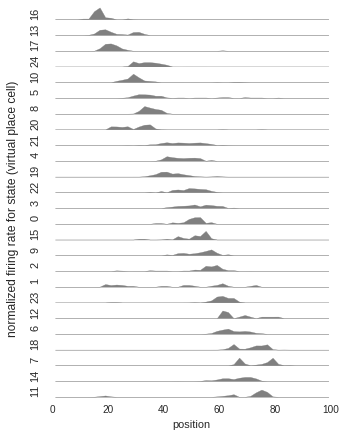

In [11]:
fig, axes = plt.subplots(num_states, 1, figsize=(5, 7), sharey=True)

for ii, ax in enumerate(axes):
    #ax.plot(xx_mid,placefields[mode_order[ii],:])
    ax.fill_between(xx_mid, 0, placefields[mode_order[ii]], color='gray')
    ax.set_ylabel(mode_order[ii])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim([0, 100])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
#fig.suptitle('normalized place fields sorted by peak location (left) and mean location (right)', y=0.92, fontsize=14)
ax.set_xticklabels(['0','20', '40', '60', '80', '100'])
ax.set_xlabel('position')
fig.text(0.0, 0.5, 'normalized firing rate for state (virtual place cell)', va='center', rotation='vertical')
#saveFigure('figures/placefields.pdf')

### Decoding accuracy

mean decoding error: 4.764
mode decoding error: 5.849
substate decoding error: 4.313


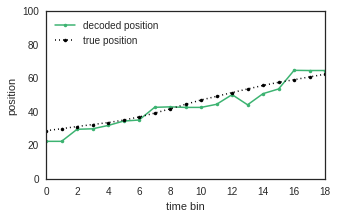

In [12]:
fig, ax2 = plt.subplots(1, 1, figsize=(5, 3))

tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(ts_b2.sequence_lengths).tolist());

seq_id = 14

obs = ts_b2.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
ll, pp = myhmm2.score_samples(obs)
seq_len = len(obs)

mean_pos = pfmeans[pp.argmax(axis=1)]
mode_pos = pfmodes[pp.argmax(axis=1)]
substate_pos = (pp*np.tile(pfmeans,(seq_len,1))).sum(axis=1)

# true position:
bb = ts_b2.boundaries[seq_id,:] # inclusive
true_pos = truepos_125[bb[0]:bb[1]+1]

#ax2.plot(mean_pos, '.', markersize=7, label='mean decoded', linestyle='dashed', linewidth=1.5, color='k')
#ax2.plot(mode_pos, '.', markersize=7, label='mode decoded', linestyle='dotted', linewidth=1.5, color='k')
ax2.plot(substate_pos,'.',markersize=7, label='decoded position', linestyle='solid', color='mediumseagreen', linewidth=1.5)
ax2.plot(true_pos,'.',markersize=7, label='true position', linestyle='dotted', color='black', linewidth=1.5)

ax2.set_ylim([0,100])
ax2.legend(loc='upper left')
ax2.set_ylabel('position')
ax2.set_xlabel('time bin')
#ax2.set_title('sequence decoding, seq {}'.format(seq_id), y=1.03)

errors = [np.sqrt(((true_pos - mean_pos)**2).mean()), np.sqrt(((true_pos -mode_pos)**2).mean()), np.sqrt(((true_pos - substate_pos)**2).mean())]
print('mean decoding error: {:2.3f}\nmode decoding error: {:2.3f}\nsubstate decoding error: {:2.3f}'.format(errors[0],errors[1],errors[2]))

#saveFigure('figures/decoding.pdf')

### State transition probability matrix

### Scoring sequences of neural activity

In [13]:
def get_replay_score_from_hmmlearn( hmmlearnModel, pth, obs ):
    # pth is a list of state indices, obs is a list (seq len) of lists (num cells) of nparray(rate)
    #P = np.exp(ymModel.dense_transition_matrix())
    logP = np.log(hmmlearnModel.transmat_)
    logPseq = 0
    logPctx = 0
    for ii in np.arange( 0, len(pth)-1 ):
        # add transition probability to sequence score:
        logPseq += logP[pth[ii],pth[ii+1]]
        # add memoryless observation likelihood to contextual score:
        logPctx += hmmlearnModel.score(obs[ii,:].reshape(1,-1)) # memoryless map probability per symbol FFFB! What about prior state probs?
        #logPctx += np.log(hmmlearnModel.predict_proba(obs[ii,:])[0][hmmlearnModel.decode(obs[ii,:])[1][0]]) # memoryless map probability per symbol FFFB! What about prior state probs?model.predict_proba(obs[ii-1,:])[0][model.decode(obs[ii-1,:])[1][0]]
        #print(logPctx)
    logPctx += hmmlearnModel.score(obs[-1,:].reshape(1,-1)) # memoryless map probability per symbol
    #logPctx += np.log(hmmlearnModel.predict_proba(obs[-1,:])[0][hmmlearnModel.decode(obs[-1,:])[1][0]]) # memoryless map probability per symbol FFFB! What about prior state probs?model.predict_proba(obs[ii-1,:])[0][model.decode(obs[ii-1,:])[1][0]]
    
    return logPseq/len(pth), logPctx/len(pth)

In [14]:
# compute replay scores on all candidate events, and compare to trajectory shuffle:
from random import shuffle

#data_to_test = seq_stk_bvr
data_to_test = seq_stk_run_125
#data_to_test = ts_b2

myStackedDataSeq = data_to_test.data.copy()
myStackedSeqLengths = data_to_test.sequence_lengths.copy()

scores_seq2 = np.zeros(len(myStackedSeqLengths))
scores_ctx2 = np.zeros(len(myStackedSeqLengths))
scores_shfl_seq2 = np.zeros(len(myStackedSeqLengths))
scores_shfl_ctx2 = np.zeros(len(myStackedSeqLengths))

ulen2 = []

seqlimits = np.cumsum(np.array([0] + list(myStackedSeqLengths)))
for ee in np.arange(0,len(myStackedSeqLengths)):
    obs = myStackedDataSeq[seqlimits[ee]:seqlimits[ee+1],:]
    lp, pth = myhmm2.decode(obs,algorithm='viterbi')
    trj_shfl_idx = np.arange(0,len(pth))
    shuffle(trj_shfl_idx)
    pth_trj_shfl = [pth[i] for i in trj_shfl_idx]
    obs_trj_shfl = np.array([obs[i] for i in trj_shfl_idx])
    
    scores_seq2[ee], scores_ctx2[ee] = get_replay_score_from_hmmlearn(myhmm2, pth, obs)
    scores_shfl_seq2[ee], scores_shfl_ctx2[ee] = get_replay_score_from_hmmlearn(myhmm2, pth_trj_shfl, obs_trj_shfl)
    #print(ee)
    
    ulen2.append(len(set(pth))) # number of unique states visited in path
    
slen2 = myStackedSeqLengths # sequence lengths


In [15]:
print(np.array(scores_seq2).mean())
print(np.array(scores_shfl_seq2).mean())
print("Average number of unique states visited per sequence: {0}".format(np.array(ulen2).mean()))

-0.803326219116
-22.8674912424
Average number of unique states visited per sequence: 7.011111111111111


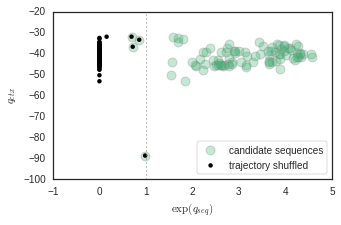

In [16]:
f, ax = plt.subplots(1,1, figsize=(5, 3))

ax.scatter(np.exp(scores_seq2)*np.array(ulen2), scores_ctx2, s=80, c='mediumseagreen', alpha=0.3, marker='o',facecolors='none', edgecolors='gray',linewidth=1, label='candidate sequences')
ax.scatter(np.exp(scores_shfl_seq2)*np.array(ulen2), scores_shfl_ctx2, c='k', s=80, marker='.',facecolors='none', edgecolors='none',linewidth=1, label='trajectory shuffled')
ax.axvline(x=1, linewidth=1, color = 'gray', linestyle='dotted')
ax.set_xlabel('$\exp(q_{seq})$')
ax.set_ylabel('$q_{ctx}$')
ax.legend(loc='lower right', fancybox=True, framealpha=0.5, frameon=True)
#ax.set_title('novel sequence score on subsequences of hc-3 data')

#saveFigure("figures/replay-score.pdf")

In [17]:
# compute replay scores on all candidate events, and compare to trajectory shuffle:
from random import shuffle

#data_to_test = seq_stk_bvr
#data_to_test = seq_stk_run_125
data_to_test = ts_b2

myStackedDataSeq = data_to_test.data.copy()
myStackedSeqLengths = data_to_test.sequence_lengths.copy()

scores_seq2 = np.zeros(len(myStackedSeqLengths))
scores_ctx2 = np.zeros(len(myStackedSeqLengths))
scores_shfl_seq2 = np.zeros(len(myStackedSeqLengths))
scores_shfl_ctx2 = np.zeros(len(myStackedSeqLengths))

ulen2 = []

seqlimits = np.cumsum(np.array([0] + list(myStackedSeqLengths)))
for ee in np.arange(0,len(myStackedSeqLengths)):
    obs = myStackedDataSeq[seqlimits[ee]:seqlimits[ee+1],:]
    lp, pth = myhmm2.decode(obs,algorithm='viterbi')
    trj_shfl_idx = np.arange(0,len(pth))
    shuffle(trj_shfl_idx)
    pth_trj_shfl = [pth[i] for i in trj_shfl_idx]
    obs_trj_shfl = np.array([obs[i] for i in trj_shfl_idx])
    
    scores_seq2[ee], scores_ctx2[ee] = get_replay_score_from_hmmlearn(myhmm2, pth, obs)
    scores_shfl_seq2[ee], scores_shfl_ctx2[ee] = get_replay_score_from_hmmlearn(myhmm2, pth_trj_shfl, obs_trj_shfl)
    #print(ee)
    
    ulen2.append(len(set(pth))) # number of unique states visited in path
    
slen2 = myStackedSeqLengths # sequence lengths


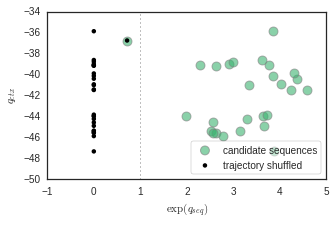

In [18]:
f, ax = plt.subplots(1,1, figsize=(5, 3))

ax.scatter(np.exp(scores_seq2)*np.array(ulen2), scores_ctx2, s=80, c='mediumseagreen', alpha=0.6, marker='o',facecolors='none', edgecolors='gray',linewidth=1, label='candidate sequences')
ax.scatter(np.exp(scores_shfl_seq2)*np.array(ulen2), scores_shfl_ctx2, c='k', s=80, marker='.',facecolors='none', edgecolors='none',linewidth=1, label='trajectory shuffled')
ax.axvline(x=1, linewidth=1, color = 'gray', linestyle='dotted')
ax.set_xlabel('$\exp(q_{seq})$')
ax.set_ylabel('$q_{ctx}$')
ax.legend(loc='lower right', fancybox=True, framealpha=0.5, frameon=True)
#ax.set_title('novel sequence score on subsequences of hc-3 data')

#saveFigure("figures/replay-score-test-only.pdf")